In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from saturation.utils import *

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
n_cores = 28

spark = (
    SparkSession.builder
    .master(f"local[{n_cores}]")
    .appName("Saturation")
    .config("spark.sql.shuffle.partitions", "500")
    .config("spark.driver.memory", "40g")
    .config("spark.driver.maxResultSize", "8g")
    .getOrCreate()
)

25/02/24 08:16:30 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.50.14 instead (on interface enp8s0)
25/02/24 08:16:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/24 08:16:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/02/24 08:16:31 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/02/24 08:16:31 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/02/24 08:16:31 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [4]:
base_path = "/data/saturation/thesis_run_20250223/"

colors = ["blue", "black", "r", "orange", "g"]
line_styles = ["-"]
font_size = 24
dpi = 400

configs_pdf, configs_df, configs_dict = get_configs(
    base_path=base_path,
    spark=spark
)

25/02/24 08:16:34 WARN CacheManager: Asked to cache already cached data.        


# Estimates of slope for each simulation

In [5]:
min_simulation_id = 1
max_simulation_id = 150
selected_simulation_ids = list(range(min_simulation_id, max_simulation_id + 1))

configs_pdf[configs_pdf.simulation_id.isin(selected_simulation_ids)].sort_values("simulation_id")

,mrp,rim_erasure_method,rmin,rmult,simulation_id,slope,stop_condition,study_region_padding,study_region_size,rim_erasure_exponent,rim_erasure_radius_ratio
81,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 0.1}",0.37,1.0,1,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",150,1200,0.1,3.0
75,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 0.2}",0.37,1.0,2,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",150,1200,0.2,3.0
70,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 0.3}",0.37,1.0,3,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",150,1200,0.3,3.0
145,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 0.4}",0.37,1.0,4,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",150,1200,0.4,3.0
96,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 0.5}",0.37,1.0,5,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",150,1200,0.5,3.0
...,...,...,...,...,...,...,...,...,...,...,...
119,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 0.6}",0.37,1.0,146,-1.0,"{'name': 'nstat', 'nstat': '2500000'}",150,1200,0.6,3.0
28,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 0.7}",0.37,1.0,147,-1.0,"{'name': 'nstat', 'nstat': '2500000'}",150,1200,0.7,3.0
59,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 0.8}",0.37,1.0,148,-1.0,"{'name': 'nstat', 'nstat': '2500000'}",150,1200,0.8,3.0
60,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 0.9}",0.37,1.0,149,-1.0,"{'name': 'nstat', 'nstat': '2500000'}",150,1200,0.9,3.0


In [6]:
target_ntot = int(2.5e6)

states = dict()
for simulation_id in selected_simulation_ids:
    state = get_states_at_ntats(
        simulation_id=simulation_id,
        configs_dict=configs_dict,
        base_path=base_path,
        target_nstats=[target_ntot],
        spark=spark
    )
    states[simulation_id] = state[target_ntot]

In [7]:
MAX_RADIUS = 20

for simulation_id, state in states.items():
    states[simulation_id] = state[state.radius < MAX_RADIUS].copy()

In [8]:
slope_estimates = []
for simulation_id, state in states.items():
    result = estimate_slopes_for_states(
        states={simulation_id: state},
        rmin=configs_dict[simulation_id]["rstat"]
    )
    result["simulation_id"] = simulation_id
    result["b_p"] = configs_dict[simulation_id]["slope"]
    result["exponent"] = configs_dict[simulation_id]["rim_erasure_method"]["exponent"]
    slope_estimates.append(result)
df = pd.concat(slope_estimates, axis=0)

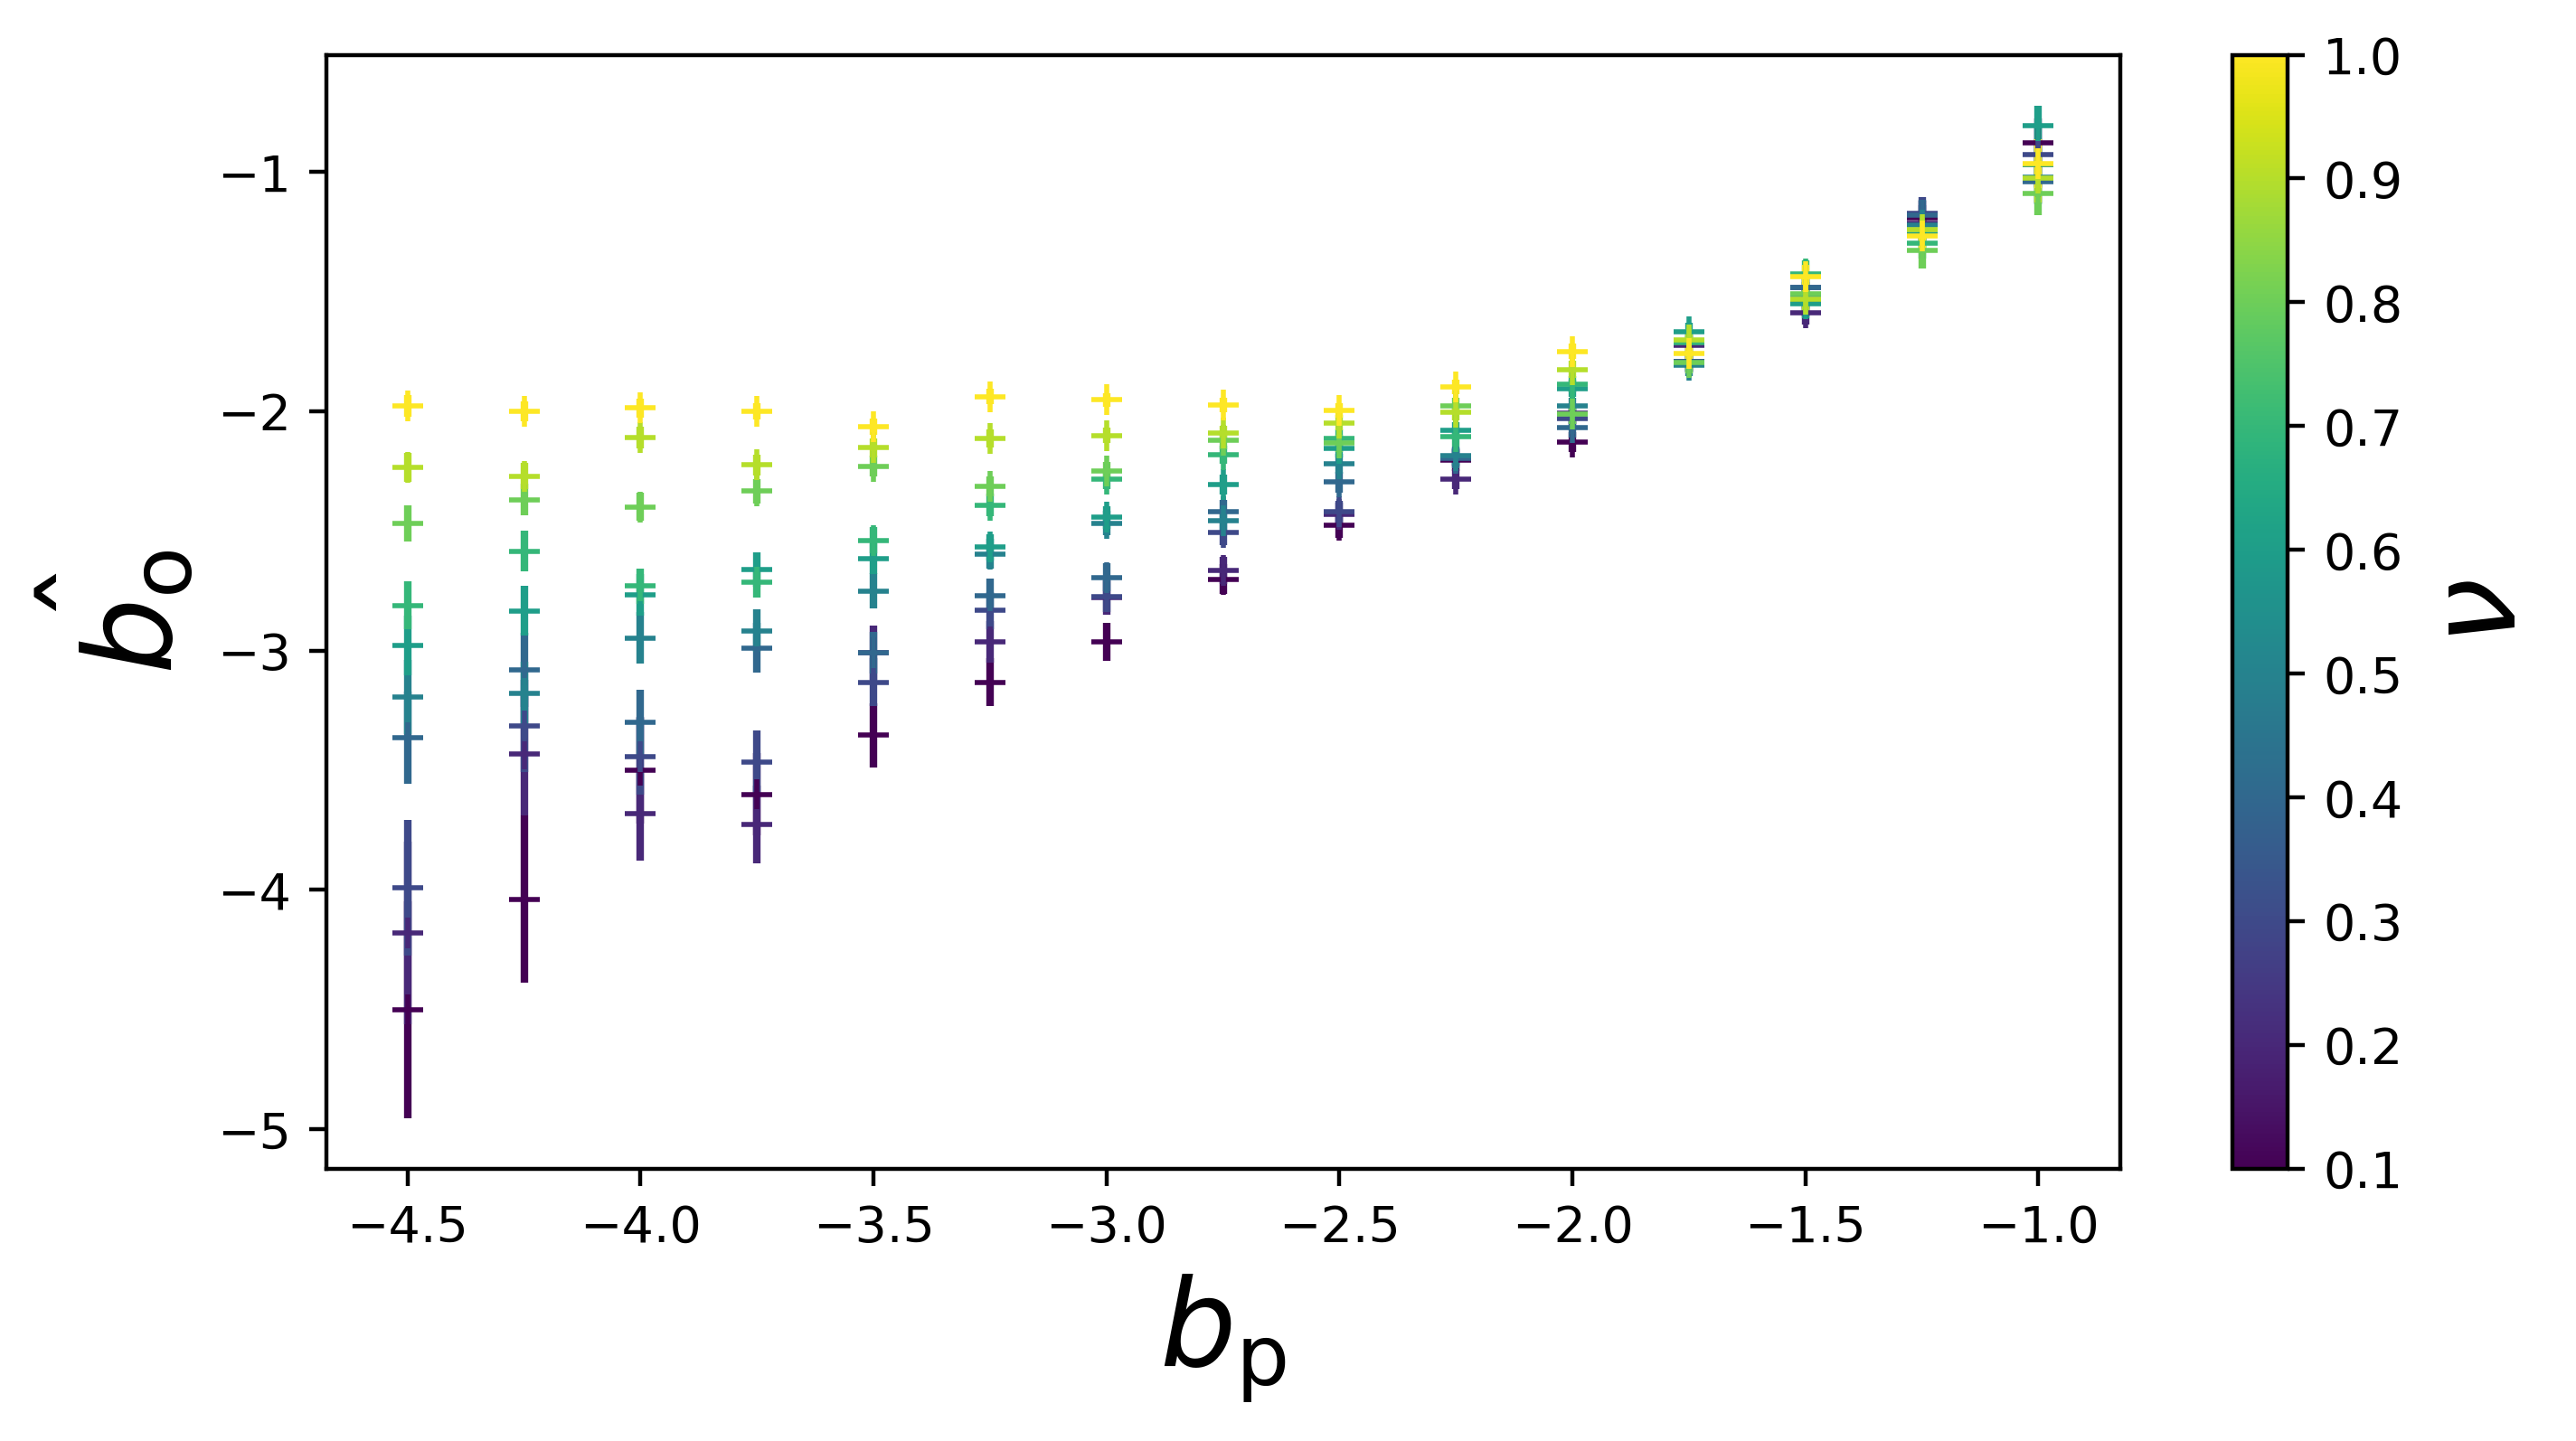

25/02/24 08:29:35 WARN JavaUtils: Attempt to delete using native Unix OS command failed for path = /tmp/blockmgr-c67de613-eae1-46a5-b296-a3e9bb3e0b1a. Falling back to Java IO way
java.io.IOException: Failed to delete: /tmp/blockmgr-c67de613-eae1-46a5-b296-a3e9bb3e0b1a
	at org.apache.spark.network.util.JavaUtils.deleteRecursivelyUsingUnixNative(JavaUtils.java:173)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:109)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:90)
	at org.apache.spark.util.SparkFileUtils.deleteRecursively(SparkFileUtils.scala:121)
	at org.apache.spark.util.SparkFileUtils.deleteRecursively$(SparkFileUtils.scala:120)
	at org.apache.spark.util.Utils$.deleteRecursively(Utils.scala:1126)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1(DiskBlockManager.scala:368)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1$adapted(DiskBlockManager.scala:364)
	at scala.collection.IndexedSeqOptimize

In [9]:
fig = plt.figure(figsize=(8, 4), dpi=dpi)
ax = fig.add_subplot(111)

# Normalize color variable to range [0, 1] for the colormap
norm = plt.Normalize(df["exponent"].min(), df["exponent"].max())

for exponent in df.exponent.drop_duplicates().sort_values():
    d = df[df.exponent == exponent].sort_values("b_p").copy()
    ax.errorbar(
        d.b_p,
        d.alpha,
        d.sigma,
        marker="+",
        ls="",
        color=cm.viridis(norm(exponent)),
        ecolor=cm.viridis(norm(exponent))
    )

sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r"$\nu$", fontsize=font_size)

ax.set_xlabel(r"$b_{\text{p}}$", fontsize=font_size)
ax.set_ylabel(r"$\hat{b_{\text{o}}}$", fontsize=font_size)

plt.savefig("figures/estimated_slopes.png", bbox_inches="tight")

plt.show()